# Анализ отзывов о интернет провайдере "Beeline KZ"
## Предисловие
Данный проект сделан в целях практики моих навыков. Все выводы сделаны из имеющихся у меня знаний и абсолютно субъективны. Причина по которой я выбрал именно эту компанию заключается в том, что я посетил крутейшую онлайн-конференцию ["BeeTech CONF"](https://beetech.kz/conf#!/tab/296879142-1) с участием очень компетентных и мощных специалистов в области Big Data. В связи с этим мне стало интресно как, изменилось ли (или не изменилось) отношение пользователей к ["Beeline KZ"](https://beeline.kz/ru) с введением таких передовых технологий. Буду очень рад и признателен услышать любые советы, сделанные мной ошибки или замечания по этой работе. Спасибо:)

In [1]:
## Import packages

# Fundamental modules
import pandas as pd
import numpy as np
from sorted_months_weekdays import Month_Sorted_Month

# Scraping modules
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as uReq
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

# Visualization modules
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# NLP modules
# pip install git+https://github.com/aatimofeev/spacy_russian_tokenizer.git
import random
import string
from spacy.lang.ru import Russian
from stop_words import get_stop_words
from nltk.probability import FreqDist

# ML modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Где взять данные?
В начале своей "аналитической карьеры" я столкнулся с парадоксальным явлением для меня, когда в секунду собираются петабайты данных, а их просто так оказывается не нагуглить. В принципе выражение _"Data is the new oil"_ начинает обретать смысл. И если ты бедный, безработный студент как я, то данные придется буквально майнить. Называя я этот процесс Data Mining, конечно бывалые дата саентисты упрекнут меня в терминологии, но в этом заключается вся ирония:)

Изначальными источниками парсинга являлись отзывы на сайтах навигации, таких как 2GIS, Yandex Карты и Google Maps. По моему мнению данные ресурсы могут содержать наиболее актуальную, репрезентативную информации о продукте от пользователей. Так как для нахождения того или иного пункта обслуживания, клиенты пользуются навигацию и как правило после оказания услуг в филиале оставляют о нем отзыв на этом же ресурсе.

Но естественно я столкнулся с проблемой на таких крупных сайтах. Основной проблемой была динамическое обновление сайта, то есть по мере скроллинга информация постоянно подгружалась из серверов. К сожалению мои навыки парсинга с помощью [_Прекрасного супа_](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) ограничивались выгрузкой данных только со статических сайтов, и получал я в итоге неполные данные. Не став отчаиваться, я пошел бороздить просторы гугла в поиске ответа. В итоге я открыл для себя очень занятную библиотеку [_"Selenium"_](https://pypi.org/project/selenium/). Она легка в использовании и проста в понимании. Что наиболее важно — библеотека позволяется автоматически скроллить сайт до определенной указанной точки.

К сожалению, по причине сложной структуры сайта с содержанием карт, данный пакет не смог интуитивно скроллить в разделе отзывов. Объяснять долго, скажу что просто не получилось:( Единственный способ - это выгрузка данных на прямую с сервера. На для этого требуется знание и понимание в архитектуре бэкэнда. Увы, я не разработчик и понять все это мне будет довольно-таки сложно.

Тут я уже отчаялся и просто прогуглил "Отзывы о Beeline KZ" и выбрал первый сайт: https://2ip.ru/isp-reviews/Beeline+KZ/. На мое удивление данный сайт содержит приличное количество отзывов из различных городов Казахстана с 11 летним периодом, а точнее с 2 апреля 2010 до 18 апреля 2021. Пробежавшись по отзывам, общее сложилось впечатление о том, что кажется больше всего недовольных отзывов. НО не аналитическое это дело, строить гипотезы на основе "кажется". Посему сделаем соответственные анализы для подтверждения или опровержения "кажется"-ов.

На этом я завешил свои поиски и начал прецесс сбора данных:

In [2]:
# Scrape reviews from https://2ip.ru/isp-reviews/Beeline+KZ/
driver = webdriver.Chrome(ChromeDriverManager().install())

# Create containers
review = []
city = []
date = []
score  = []

# Loop over all pages
for i in range(1,73):
    url = 'https://2ip.ru/isp-reviews/Beeline+KZ/?pageId=' + str(i) + '&orderBy=id&itemPerPage=10'
    driver.get(url)
    
    reviews = driver.find_elements_by_class_name('reviewItem__txt')
    for post in reviews:
        review += [post.text]
    
    cities = driver.find_elements_by_class_name('reviewItem__Город')
    for town in cities:
        city += [town.text]
        
    dates = driver.find_elements_by_class_name('reviewItem__date')
    for day in dates:
        date += [day.text]

    uClient = uReq(url)
    page_html = uClient.read()
    uClient.close()
    page_soup = soup(page_html, 'html.parser')
    rating = page_soup.findAll("div", {"class":"provider-rating__item"})
    
    # scrape rating of each category 
    for j in range(0,len(rating),4):
        speed = 0
        availability = 0
        service = 0
        price_quality = 0 
        for s in rating[j].findAll("img", {"alt":"rating"}):
            if "full" in str(s):
                speed += 1

        for s in rating[j+1].findAll("img", {"alt":"rating"}):
            if "full" in str(s):
                availability += 1

        for s in rating[j+2].findAll("img", {"alt":"rating"}):
            if "full" in str(s):
                service += 1

        for s in rating[j+3].findAll("img", {"alt":"rating"}):
            if "full" in str(s):
                price_quality += 1

        score += [[speed, availability, service, price_quality]]

# Convert to Pandas DataFrame and import as csv
reviews = pd.DataFrame(list(zip(date, Город, review)), columns=['Дата','Город', 'Отзыв'])\
            .join(pd.DataFrame(score, columns=['Скорость', 'Доступность', 'Служба поддержки', 'Цена/качество']))

# add average rating 
reviews['Рейтинг'] = reviews.iloc[:,3:7].mean(axis=1)

# reviews.to_csv('Beeline_KZ_reviews.cvs', index=False)

# Чистка данных и Описательный анализ (или графики, таблицы и что мы тут насобирали...)  
Используя выше разработанные алгоритмы парсинга, позволили выгрузить данные с информацией о дате, городе, рейтинге и самом отзыве. Я все это сохраним в удобном _csv_ формате для многократного использования датасета в дальнейшем. Итак, приступим.

In [3]:
# Import scraped dataset
reviews = pd.read_csv('Beeline_KZ_reviews.cvs')

# Inspect dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Дата              712 non-null    object 
 1   Город             712 non-null    object 
 2   Отзыв             712 non-null    object 
 3   Скорость          712 non-null    int64  
 4   Доступность       712 non-null    int64  
 5   Служба поддержки  712 non-null    int64  
 6   Цена/качество     712 non-null    int64  
 7   Рейтинг           712 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 44.6+ KB


In [4]:
# Observe dataset
reviews.head(10)

,Дата,Город,Отзыв,Скорость,Доступность,Служба поддержки,Цена/качество,Рейтинг
0,18 апреля в 19:33,г. Нур-Султан,Здравствуйте. Хочу оставить отзыв о качестве с...,1,4,2,2,2.25
1,03 апреля в 18:32,г. Уральск,"Скорость лучше чем в КЗ телеком, но постоянно ...",3,3,5,2,3.25
2,30 марта в 11:08,г. Алматы,Очень плохая скорость интернета тариф яркий за...,1,1,1,1,1.00
3,29 марта в 17:07,г. Караганда,"3 месяца не могут решить проблему с обрывами, ...",1,2,1,1,1.25
4,28 марта в 10:48,г. Караганда,"Интернет там где я живу, очень хороший. При по...",4,5,3,5,4.25
5,23 марта в 22:58,г. Караганда,Скорость интернета даже не пахнет их хваленным...,1,1,1,1,1.00
6,23 марта в 18:57,г. Алматы,"Интернет постоянно отключатеся, пинг скачет, с...",1,2,1,1,1.25
7,17 марта в 12:41,г. Нур-Султан,"Вечная потеря пакетов, перебои в сетях, мелкие...",1,1,1,1,1.00
8,11 марта в 17:47,г. Атырау,"Интернет очень сильно лагает, каждые 10-15 мин...",2,2,1,1,1.50
9,11 марта в 17:01,г. Алматы,"Худший провайдер. После нового года, каждый де...",2,3,3,2,2.50


In [5]:
# Number of unique cities 
reviews.Город.nunique()

43

In [6]:
# Number of reviews from each city
reviews.Город.value_counts()

г. Алматы              191
г. Караганда           108
г. Нур-Султан           61
г. Павлодар             48
г. Петропавловск        30
г. Усть-Каменогорск     29
г. Костанай             25
г. Тараз                22
г. Актобе               20
г. Темиртау             18
г. Шымкент              17
г. Экибастуз            17
г. Семей                12
г. Уральск              12
г. Кокшетау             12
г. Балхаш               11
г. Атырау               10
г. Рудный               10
г. Жезказган             8
г. Талдыкорган           8
г. Байконур              7
г. Кызылорда             6
г. Семипалатинск         6
г. Актау                 3
г. Абай                  2
г. Усть-Камчатск         2
г. Степняк               1
г. Лисаковск             1
г. Житикара              1
г. Риддер                1
г. Чимкент               1
г. Щучинск               1
г. Харьков               1
г. Джезказган            1
г. Атбасар               1
г. Ростов-на-Дону        1
г. Санкт-Петербург       1
г

In [7]:
# Drop cities which are not in KZ
reviews = reviews.drop(reviews.loc[(reviews.Город == 'г. Ростов-на-Дону') | (reviews.Город == 'г. Москва') |
           (reviews.Город == 'г. Харьков') | (reviews.Город == 'г. Санкт-Петербург') | (reviews.Город == 'г. Усть-Камчатск')].index, axis=0)

# Reset indexes
reviews = reviews.reset_index(drop=True)

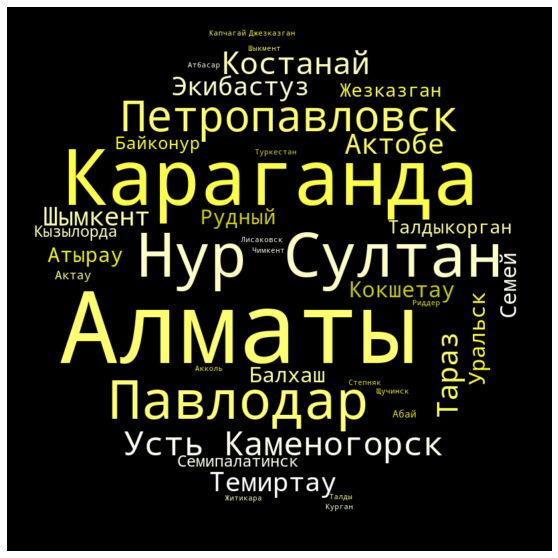

In [8]:
# Generate a word cloud image
text = " ".join(review for review in reviews.Город.str.replace('г. ',''))
mask =  np.array(Image.open("..//Beeline KZ/images/beeline.png"))
wordcloud = WordCloud(background_color="black", mask=mask).generate(text)

def yellow_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(61, 100%%, %i%%)" % random.randint(40, 100)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=yellow_color_func), interpolation="bilinear")
plt.axis("off")
# plt.savefig('..//Beeline KZ/images/cities_cloud.jpeg', bbox_inches='tight')
plt.show()

Итак, у нас в итоге __712__ отзывов из _43_ различных городов, 5 из которых не из Казахстана (мы их соответственно уберем) с 2010-04-02 до 2021-04-18. Больше всего отзывов оставили из города _Алматы_, количество отзывов которого почти вдвое больше, чем у города на втором месте... __Караганда__? Для меня это удивительно, так как в голове я коррелировал количество отзывов по населению (то есть чем больше население, тем больше отзывов). Хоть и Караганда входит в пятерку самых населенных городов Казахстана, но так высоко и с таким отрывов ее увидеть я не ожидал. Тем не менее это очень интересное наблюдение. График ниже позволяет сделать наиболее наглядное сравнение:

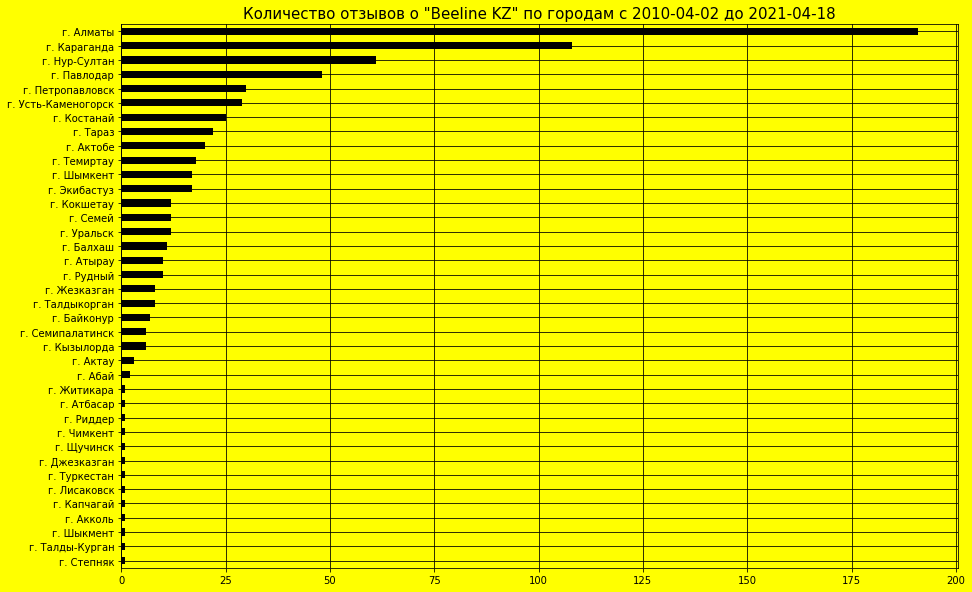

In [9]:
# Plot bar chart of the total number of reviews by Город 
fig = plt.figure(figsize=(15, 10),facecolor='yellow')
ax = plt.axes()
ax.set_facecolor("yellow")
reviews.Город.value_counts().sort_values().plot(kind='barh', color='black')
plt.grid(color='black')
plt.setp(ax.spines.values(), color='black')
plt.title('Количество отзывов о "Beeline KZ" по городам с 2010-04-02 до 2021-04-18', fontsize=15)
# plt.savefig('..//Beeline KZ/images/Количество отзывов о Beeline KZ по городам с 2010-04-02 до 2021-04-18.jpeg', bbox_inches='tight',
#            facecolor=fig.get_facecolor(), transparent=True)
plt.show()

# Анализ временных рядов

Относительно большой промежуток времени позволяет сделать так называемый анализ временных рядов. А точнее, меня интересует:
- как часто абоненты Билайн оставляют отзывы на этом сайте в течение дня, месяца, года;
- В какое время суток абоненты чаще всего оставляют отзывы;
- Имеются ли закономерности и паттерны между годами

Для ответа на все вопросы требуется предобработка и чистка данных. После чего мы попытаемся построить и интерпретировать графики.

In [10]:
# Split date and time 
reviews['Время'] = reviews.Дата.str.split(' в ', expand=True)[1]
reviews['Дата'] = reviews.Дата.str.split(' в ', expand=True)[0]

In [11]:
# Clean date column 
reviews.loc[reviews.Дата.str.contains(' '), 'Дата'] = reviews[reviews.Дата.str.contains(' ')].Дата + ' 2021'
reviews = reviews.replace(regex={' января ': '.01.', ' февраля ': '.02.', ' марта ': '.03.',' апреля ': '.04.'})

# Convert date and time to datetime 
reviews.Дата = pd.to_datetime(reviews.Дата, format='%d.%m.%Y')
reviews.Время = pd.to_datetime(reviews.Время, format='%H:%M').dt.time

In [12]:
# Date range of dataset
print('Временной период отзывов с', reviews.Дата.dt.date.min(), 'до', reviews.Дата.dt.date.max())

Временной период отзывов с 2010-04-02 до 2021-04-18


In [13]:
# Average review per day and month
print('Среднее кол-во отзывов в день:',round(reviews.Дата.value_counts().mean(), 2))
print('Среднее кол-во отзывов в месяц:',round(reviews.Дата.dt.to_period('M').value_counts().mean(), 2))

Среднее кол-во отзывов в день: 1.15
Среднее кол-во отзывов в месяц: 5.88


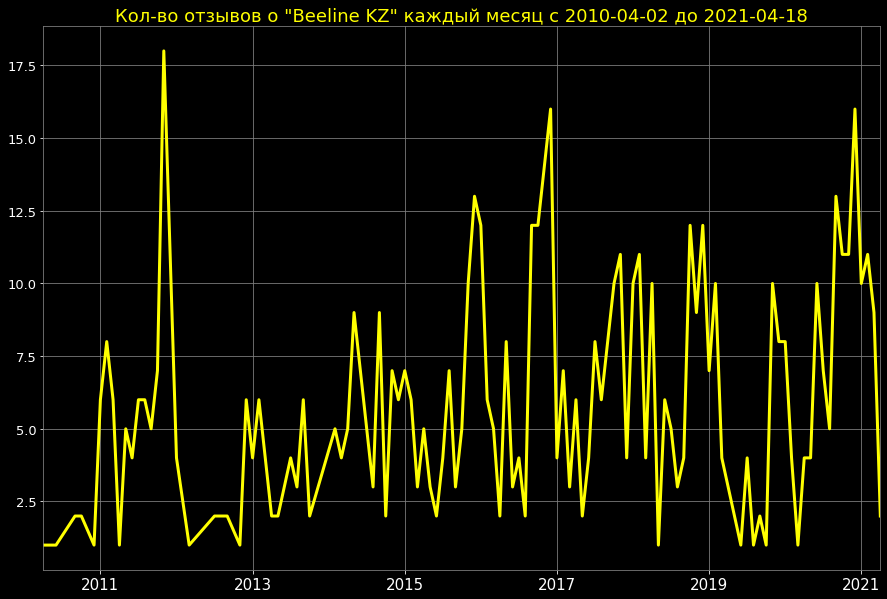

In [14]:
# Total number of reviews for each month
fig = plt.figure(figsize=(15, 10),facecolor='black')
ax = plt.axes()
ax.tick_params(axis='x', colors='white', labelsize=15) 
ax.tick_params(axis='y', colors='white', labelsize=13) 
ax.spines['bottom'].set_color('white')
ax.set_facecolor("black")
reviews.Дата.dt.to_period('M').value_counts().sort_index().plot(color='yellow', linewidth=3)
plt.title('Кол-во отзывов о "Beeline KZ" каждый месяц с 2010-04-02 до 2021-04-18', fontsize=18, color='yellow')
plt.grid(color='grey')
plt.setp(ax.spines.values(), color='grey')
# plt.savefig('..//Beeline KZ/images/Количество отзывов о Beeline KZ каждый месяц с 2010-04-02 до 2021-04-18.jpeg', bbox_inches='tight',
#            facecolor=fig.get_facecolor(), transparent=True)
plt.show()

На графике выше показано количество оставленных отзывов для каждого дня в течение данного периода. При этом в среднем оставлялось минимум по 1 отзыву в день. Нет явно выраженных трендов и можно утверждать, что временной график стационарен и признаков каких-либо изменений не наблюдается. Но есть признаки сезонности. В некоторых промежутках времени количество отзывов резко росло к концу года и падало в начале года. Давайте посмотрим на гистограмму отзывов по месяцам и убедимся в этом.

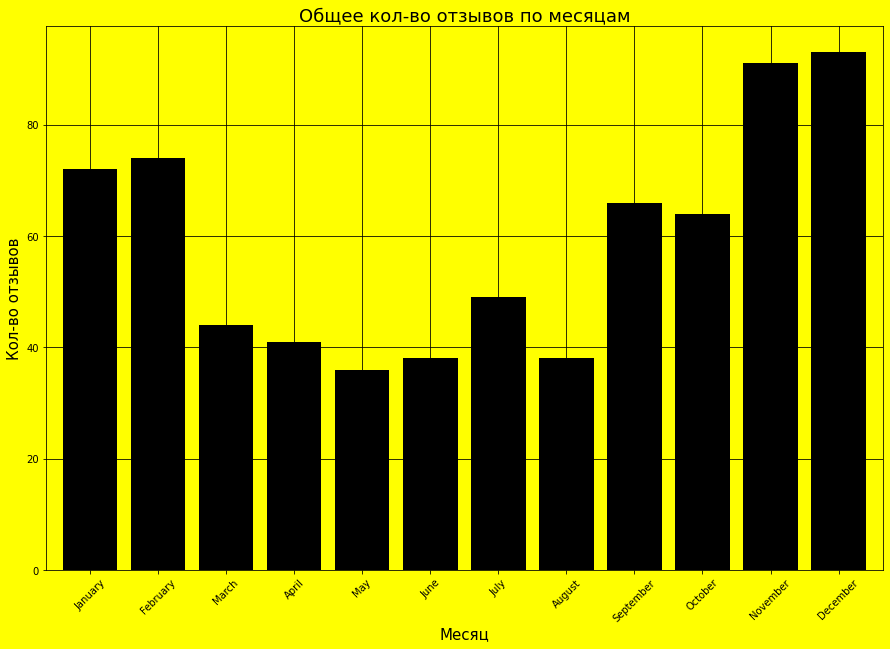

In [15]:
# Plot bar chart of the total number of reviews by month 
fig = plt.figure(figsize=(15, 10),facecolor='yellow')
ax = plt.axes()
ax.set_facecolor("yellow")
reviews.Дата.dt.strftime('%B').value_counts().loc[Month_Sorted_Month(reviews.Дата.dt.strftime('%B').value_counts().index)]\
       .plot(kind='bar', color='black', width = 0.8)
plt.xlabel('Месяц', fontsize=15)
plt.xticks(rotation=45)
plt.ylabel('Кол-во отзывов', fontsize=15)
plt.title('Общее кол-во отзывов по месяцам', fontsize=18)
plt.grid(color='black')
plt.setp(ax.spines.values(), color='black')
# plt.savefig('..//Beeline KZ/images/Общее кол-во отзывов по месяцам с 2010-04-02 до 2021-04-18.jpeg', bbox_inches='tight',
#            facecolor=fig.get_facecolor(), transparent=True)
plt.show()

Основываясь на этот график, можно предположить, что каждый месяц клиенты отставляли неодинаковое количество отзывов и нельзя полагаться на 5.88 (среднее кол-во отзывов в месяц). Действительно, ноябрь и декабрь самые активные месяцы. Далее идут с понижением январь и февраль. Видимо весенняя оттепель дает о себе знать и как-то резко снижает количество отзывов. Возникает вопрос, что так влияет на дисбаланс отзывов по месяцам, и как погодные условия влияют на качество связи. Неужели при плохой погоде падает качество связи (при условии того, что большинство отзывов негативные) или верно обратное? Выяснить причины будет довольно сложно, уж слишком много факторов и мало данных. Вопрос остается открытым...

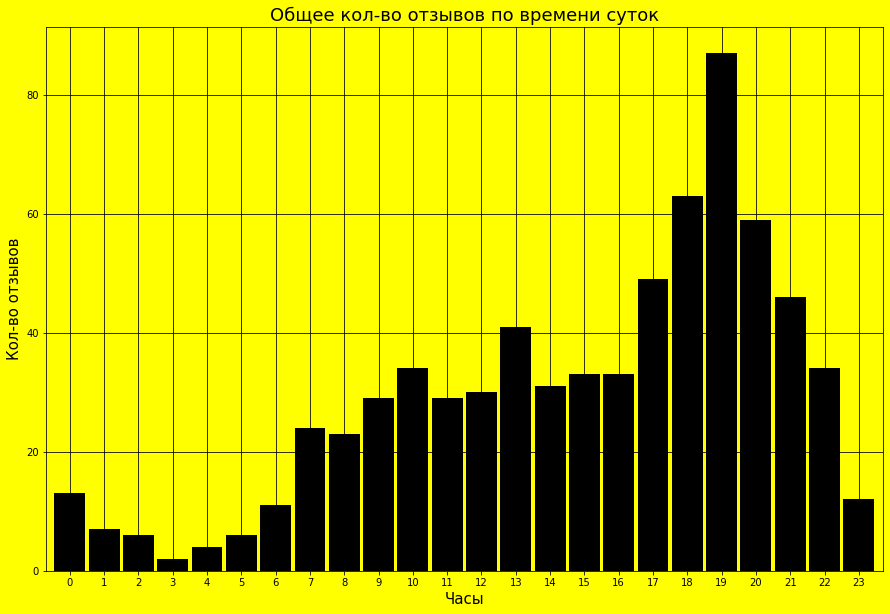

In [16]:
# Plot bar chart of the total number of reviews by hour 
fig = plt.figure(figsize=(15, 10),facecolor='yellow')
ax = plt.axes()
ax.set_facecolor("yellow")
pd.to_datetime(reviews.Время.astype('str')).dt.hour.value_counts().sort_index().plot(kind='bar', color='black', width = 0.9)
plt.xlabel('Часы', fontsize=15)
plt.xticks(rotation=0)
plt.ylabel('Кол-во отзывов', fontsize=15)
plt.title('Общее кол-во отзывов по времени суток', fontsize=18)
plt.grid(color='black')
plt.setp(ax.spines.values(), color='black')
# plt.savefig('..//Beeline KZ/images/Общее кол-во отзывов по времени суток с 2010-04-02 до 2021-04-18.jpeg', bbox_inches='tight',
#            facecolor=fig.get_facecolor(), transparent=True)
plt.show()

Абоненты Билайн чаще всего оставляли свои ~~недовольные~~ отзывы начиная с 5 вечера. Пик достигался в 19 часов и постeпено стихал до самой полуночи. Это хорошо коррелируется с пиком использования интернета в стране. Возможно, в вечерний прайм-тайм идет нагрузка на сеть, что ведет за собой моментальный фитбэк на то, как сеть справляется с нагрузкой.

# "Сентиментальный" анализ отзывов

Итак, настало время самого сложного, но очень интересного — это обработка самих отзывов и комментариев. Я не специалист в NLP, тем более тут есть свои тонкости и нюансы в обработке русского текста. И посему мой анализ текста будет очень тривиален. Задачей на этом этапе будет проанализировать частоту используемых слов во всех положительных и отрицательных отзывах и построить классификатор. Надеюсь это даст общее представление о продукте от пользователей.

Для начала давайте посмотрим на средние оценки по категориям и общий рейтинг:

In [17]:
print(reviews.iloc[:,3:8].mean().round(2))

Скорость            2.38
Доступность         2.62
Служба поддержки    2.31
Цена/качество       2.32
Рейтинг             2.41
dtype: float64


Не очень утешительные средние оценки. Общий рейтинг и оценки по всем категориям от пользователей "Beeline KZ" ниже среднего. Но давайте не будем отчаиваться, так как эти средние показатели не отражают динамику оценок в течение времени и возможно есть некоторые улучшения в последние годы. Для этого построим график средних оценок для каждого года и проанализируем тенденцию.

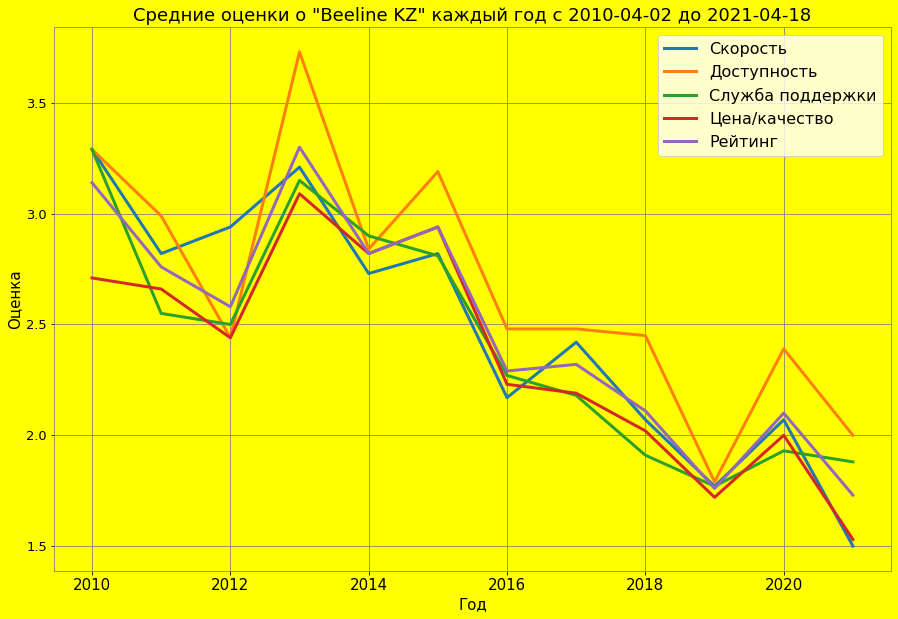

In [18]:
fig = plt.figure(figsize=(15, 10),facecolor='yellow')
ax = plt.axes()
ax.tick_params(axis='x', colors='black', labelsize=15) 
ax.tick_params(axis='y', colors='black', labelsize=13) 
ax.spines['bottom'].set_color('black')
ax.set_facecolor("yellow")
reviews.groupby(reviews.Дата.dt.year).mean().round(2).plot(ax=ax, linewidth=3)
plt.xlabel('Год', fontsize=15)
plt.ylabel('Оценка', fontsize=15)
plt.grid(color='grey')
plt.setp(ax.spines.values(), color='grey')
plt.title('Средние оценки о "Beeline KZ" каждый год с 2010-04-02 до 2021-04-18', fontsize=18, color='black')
plt.legend(prop={'size': 16})
# plt.savefig('..//Beeline KZ/images/Средние оценки о Beeline KZ каждый год с 2010-04-02 до 2021-04-18.jpeg', 
#             bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)
plt.show()

К сожалению ситуация лишь только ухудшилась. Основываясь на графике выше, средние оценки по категориям и общий рейтинг падали с каждым годом. Небольшое улучшение было в 2020 году, но оценки сразу же рухнули уже в следующем году. Но что же может быть проблемой таких низких оценок? Давайте проанализируем сами отзывы, чтобы выяснить это.

Для начала классифицируем наши отзывы на положительные и отрицательные, основываясь на общий рейтинг. Порог деления будет оценка в 3 балла, то есть если оценка выше трех, то отзыв положительный (1), соответственно ниже трех или равно трем — отрицательный (0). Затем постоим талицу частот используемых слов и облако слов для каждой категории отзывов и выясним о чем пишут пользователи.

In [19]:
# label comments to positive and negative
reviews['sentiment'] = np.where(reviews.Рейтинг > 3, 1,0)

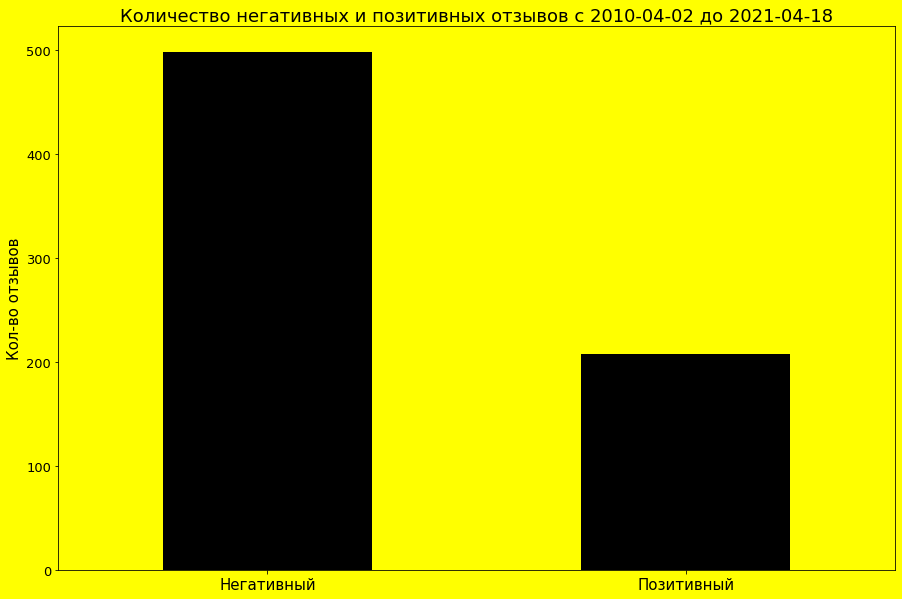

In [20]:
# Number of pos. and neg. comments
fig = plt.figure(figsize=(15, 10),facecolor='yellow')
ax = plt.axes()
ax.tick_params(axis='x', colors='black', labelsize=15) 
ax.tick_params(axis='y', colors='black', labelsize=13) 
ax.set_facecolor("yellow")
reviews.sentiment.replace({0:'Негативный', 1:'Позитивный'}).value_counts().plot(kind='bar', color="black")
plt.xticks(rotation=0)
plt.title('Количество негативных и позитивных отзывов с 2010-04-02 до 2021-04-18', fontsize=18, color='black')
plt.ylabel('Кол-во отзывов', fontsize=15)
# plt.savefig('..//Beeline KZ/images/Количество негативных и позитивных отзывов с 2010-04-02 до 2021-04-18.jpeg', 
#             bbox_inches='tight', facecolor=fig.get_facecolor(), transparent=True)
plt.show()

Количество негативных отзывов в этот временной промежуток превышывает количество позитивных отзывов почти в 3 раза. Для начала проанилизируем первый позитивный отзыв.

In [21]:
# split pos. and neg. comments
pos = reviews[reviews.sentiment == 1].reset_index(drop=True)
neg = reviews[reviews.sentiment == 0].reset_index(drop=True)

In [22]:
pos.Отзыв[0]

'Скорость лучше чем в КЗ телеком, но постоянно скачет, хотя использую их модем, тариф за 5500, Если играете во что-то, то там вас ждет тоже самое с пингом, в этом плане КЗ телеком стабильнее хоть и пинг за 100,тут же пинг всегда скачет от 80 до 300 спокойно может подняться раз 20 за один раунд в кс допустим, ну или пример с другом решили кооп игру поиграть он живет в Самаре расстояние небольшое, а пинг скачет так что играть не возможно, да даже на кз серверах он всегда скачет с 30 до 60 и из-за этого лагает и играть нереально, игра будто фризит хотя комп далеко не слабый и тянет все на ура фпс в онлайн играх от 250.'

Довольно-таки объемный текст и содержит много информации. Но так как мы сейчас фокусируемся только на словах, то наличие пунктуации не имеет смысла. Используя соответствующие модули можно отсеять пунктуацию. Так же мы знаем, что не все люди пишут имена собственные с заглавной буквы, так что лучше перевести все слова в прописные. Затем мы разобьём слова друг от друга и поместим отзыв в список. В итоге получится элемент, который называется "токен".

In [23]:
# Tokenize 1st positive review
text = pos.Отзыв.str.lower()[0]
text = "".join([ch for ch in text if ch not in string.punctuation])
nlp = Russian()
doc = nlp(text)
token =[token.text for token in doc]
print(token)

['скорость', 'лучше', 'чем', 'в', 'кз', 'телеком', 'но', 'постоянно', 'скачет', 'хотя', 'использую', 'их', 'модем', 'тариф', 'за', '5500', 'если', 'играете', 'во', 'чтото', 'то', 'там', 'вас', 'ждет', 'тоже', 'самое', 'с', 'пингом', 'в', 'этом', 'плане', 'кз', 'телеком', 'стабильнее', 'хоть', 'и', 'пинг', 'за', '100тут', 'же', 'пинг', 'всегда', 'скачет', 'от', '80', 'до', '300', 'спокойно', 'может', 'подняться', 'раз', '20', 'за', 'один', 'раунд', 'в', 'кс', 'допустим', 'ну', 'или', 'пример', 'с', 'другом', 'решили', 'кооп', 'игру', 'поиграть', 'он', 'живет', 'в', 'самаре', 'расстояние', 'небольшое', 'а', 'пинг', 'скачет', 'так', 'что', 'играть', 'не', 'возможно', 'да', 'даже', 'на', 'кз', 'серверах', 'он', 'всегда', 'скачет', 'с', '30', 'до', '60', 'и', 'изза', 'этого', 'лагает', 'и', 'играть', 'нереально', 'игра', 'будто', 'фризит', 'хотя', 'комп', 'далеко', 'не', 'слабый', 'и', 'тянет', 'все', 'на', 'ура', 'фпс', 'в', 'онлайн', 'играх', 'от', '250']


Отлично! Пунктуация отсутствует, но теперь токен содержит предлоги, союзы и местоимения, которые не имеют важной для нас смысловой нагрузки. Такие слова называют стоп словами. Их мы тоже может отсеять:  

In [24]:
# Remove stop words
stop_words = get_stop_words('russian')
token = [word for word in token if word not in stop_words]
print(token)

['скорость', 'кз', 'телеком', 'постоянно', 'скачет', 'использую', 'модем', 'тариф', '5500', 'играете', 'чтото', 'ждет', 'самое', 'пингом', 'плане', 'кз', 'телеком', 'стабильнее', 'пинг', '100тут', 'пинг', 'скачет', '80', '300', 'спокойно', 'подняться', '20', 'раунд', 'кс', 'допустим', 'пример', 'другом', 'решили', 'кооп', 'игру', 'поиграть', 'живет', 'самаре', 'расстояние', 'небольшое', 'пинг', 'скачет', 'играть', 'возможно', 'кз', 'серверах', 'скачет', '30', '60', 'изза', 'лагает', 'играть', 'нереально', 'игра', 'фризит', 'комп', 'слабый', 'тянет', 'ура', 'фпс', 'онлайн', 'играх', '250']


В конец концов применим выше описанные и проделанные манипуляции ко всем положительными и отрицательным отзывам. Зачет посчитаем частоту каждого слова.

In [25]:
# Tokenize all positive review
pos_tokens = []
for i in range(len(pos.Отзыв)):
    text = pos.Отзыв.str.lower()[i]
    text = "".join([ch for ch in text if ch not in string.punctuation + '—\n«»0123456789' + string.ascii_lowercase])
    nlp = Russian()
    doc = nlp(text)
    token = [token.text for token in doc]
    pos_tokens += [word for word in token if word not in stop_words]
len(pos_tokens)

5924

In [26]:
# Top-20 common used words
fdist = FreqDist(pos_tokens)
fdist.most_common(20)

[(' ', 396),
 ('скорость', 135),
 ('интернет', 127),
 ('билайн', 58),
 ('провайдер', 41),
 ('  ', 40),
 ('интернета', 35),
 ('пинг', 32),
 ('работает', 32),
 ('хороший', 29),
 ('провайдера', 29),
 ('пользуюсь', 26),
 ('дома', 26),
 ('скорости', 25),
 ('поддержки', 23),
 ('проблемы', 20),
 ('тариф', 19),
 ('мбс', 19),
 ('устраивает', 19),
 ('мегалайн', 17)]

Из 5924 слов позитивных отзывов верхнюю строчу нашего списка часто используемых слов занимают не совсем слова или слова несущие, по-моему мнению, очень мало смысла. Мы может так же добавить эти "стоп-слова" в наш черный список.

In [27]:
# Add stop words to list 
stop_words.extend([' ', '  ', 'билайн', '…', 'изза', 'билайна'])

In [28]:
# Tokenize all positive review again
pos_tokens = []
for i in range(len(pos.Отзыв)):
    text = pos.Отзыв.str.lower()[i]
    text = "".join([ch for ch in text if ch not in string.punctuation + '—\n«»0123456789' + string.ascii_lowercase])
    nlp = Russian()
    doc = nlp(text)
    token = [token.text for token in doc]
    pos_tokens += [word for word in token if word not in stop_words]
len(pos_tokens)

5397

In [29]:
# Top-20 common used words
fdist = FreqDist(pos_tokens)
fdist.most_common(20)

[('скорость', 135),
 ('интернет', 127),
 ('провайдер', 41),
 ('интернета', 35),
 ('пинг', 32),
 ('работает', 32),
 ('хороший', 29),
 ('провайдера', 29),
 ('пользуюсь', 26),
 ('дома', 26),
 ('скорости', 25),
 ('поддержки', 23),
 ('проблемы', 20),
 ('тариф', 19),
 ('мбс', 19),
 ('устраивает', 19),
 ('мегалайн', 17),
 ('бывают', 17),
 ('интернетом', 16),
 ('мб', 16)]

В позитивных отзывав люди часто писали о скорости интернета. Так же в таблице имеются такие "позитивные" слова, как "работает", "хороший", "устраивает". Вместо того, чтобы выводить всю огромную таблицу частот используемых слов, мы можем построить облако, где цвет и размер характеризует частоту. То есть чем больше слово, тем чаще его использовали. 

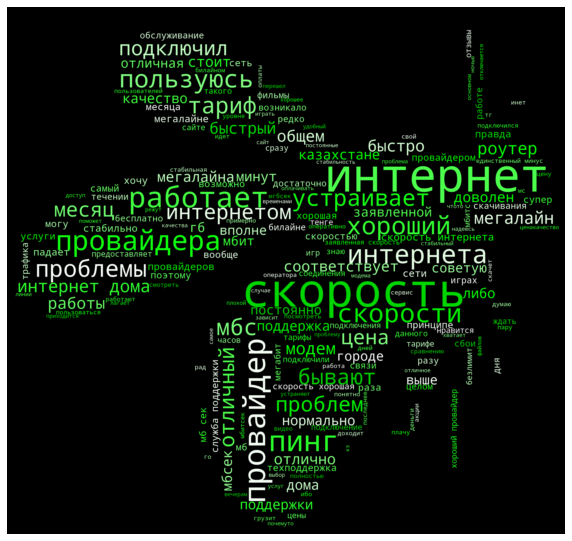

In [30]:
# Generate a word cloud image
text = " ".join(word for word in pos_tokens)
mask =  np.array(Image.open("..//Beeline KZ/images/bee.png"))
wordcloud = WordCloud(background_color="black", mask=mask).generate(text)

def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(120, 100%%, %d%%)" % random.randint(40, 100)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=green_color_func), interpolation="bilinear")
plt.axis("off")
# plt.savefig('..//Beeline KZ/images/pos_words_cloud.jpeg', bbox_inches='tight')
plt.show()

In [31]:
neg_tokens = []
for i in range(len(neg.Отзыв)):
    text = neg.Отзыв.str.lower()[i]
    text = "".join([ch for ch in text if ch not in string.punctuation + '—\n«»0123456789' + string.ascii_lowercase])
    nlp = Russian()
    doc = nlp(text)
    token = [token.text for token in doc]
    neg_tokens += [word for word in token if word not in stop_words]
len(neg_tokens)

15728

In [32]:
fdist = FreqDist(neg_tokens)
fdist.most_common(20)

[('интернет', 338),
 ('скорость', 309),
 ('вообще', 103),
 ('интернета', 95),
 ('работает', 77),
 ('скорости', 72),
 ('пинг', 69),
 ('минут', 66),
 ('постоянно', 63),
 ('мб', 60),
 ('деньги', 58),
 ('дома', 58),
 ('тариф', 55),
 ('месяца', 54),
 ('поддержки', 53),
 ('месяц', 49),
 ('мбс', 49),
 ('провайдера', 48),
 ('связи', 45),
 ('провайдер', 44)]

Забавно то, что топ-20 часто используемых слов в негативные отзывав почти такие же, как и топ-20 часто используемых слов в положительных отзывав. Возникает ощущение того, что пользователи хвалят и критикуют одни и те же услугу "Beeline KZ". На самом деле, как для аналитика, это очень печальный вывод, так как не дает ответа на вопрос, чем же довольны или не довольны пользователи. Так же нельзя выявить какие-либо закономерности или паттерны.

Давайте построим облако слов для негативных отзывов.

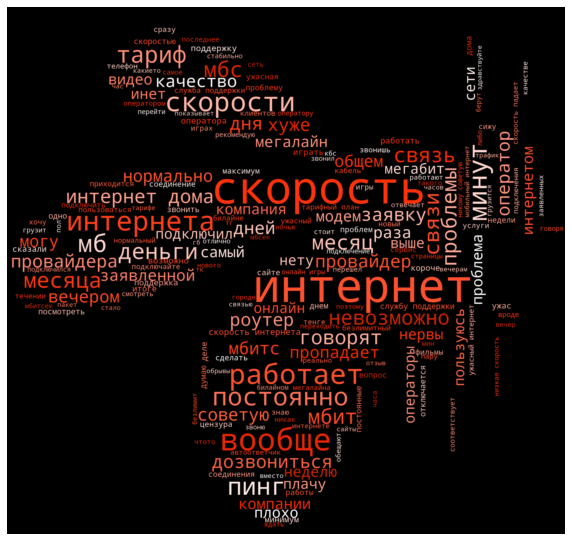

In [33]:
# Generate a word cloud image
text = " ".join(word for word in neg_tokens)
mask =  np.array(Image.open("..//Beeline KZ/images/bee.png"))
wordcloud = WordCloud(background_color="black", mask=mask).generate(text)

def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(10, 100%%, %d%%)" % random.randint(40, 100)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=red_color_func), interpolation="bilinear")
plt.axis("off")
# plt.savefig('..//Beeline KZ/images/neg_words_cloud.jpeg', bbox_inches='tight')
plt.show()

Проблемой может быть удаление частицы "не" из списка слов, которая может отражать удовлетворенность или недовольство провайдером. Единственным способ решить эту проблему для меня - это объединить частицу со словом. Далее сравним наши таблицы частот после этой манипуляции.

In [34]:
reviews.loc[reviews.Отзыв.str.contains('не '), 'Отзыв'] = reviews.loc[reviews.Отзыв.str.contains('не '), 'Отзыв'].replace(regex={'не ': 'не'})
neg = reviews[reviews.sentiment == 0].reset_index(drop=True)

In [35]:
neg_tokens = []
for i in range(len(neg.Отзыв)):
    text = neg.Отзыв.str.lower()[i]
    text = "".join([ch for ch in text if ch not in string.punctuation + '—\n«»0123456789' + string.ascii_lowercase])
    nlp = Russian()
    doc = nlp(text)
    token = [token.text for token in doc]
    neg_tokens += [word for word in token if word not in stop_words]
len(neg_tokens)

15891

In [36]:
fdist = FreqDist(neg_tokens)
fdist.most_common(20)

[('интернет', 323),
 ('скорость', 306),
 ('вообще', 103),
 ('интернета', 94),
 ('скорости', 71),
 ('пинг', 69),
 ('минут', 66),
 ('постоянно', 63),
 ('мб', 60),
 ('деньги', 58),
 ('дома', 58),
 ('тариф', 55),
 ('невозможно', 55),
 ('месяца', 54),
 ('поддержки', 53),
 ('месяц', 49),
 ('мбс', 49),
 ('провайдера', 46),
 ('работает', 46),
 ('связи', 44)]

Итак количество слова "работает" уменьшилось. Это говорит о том, что часть слов преобразолось в "неработает". Это может дать более ясное представление об негативных отзывах. Снова постоим облако слов для негативных комментариев. 

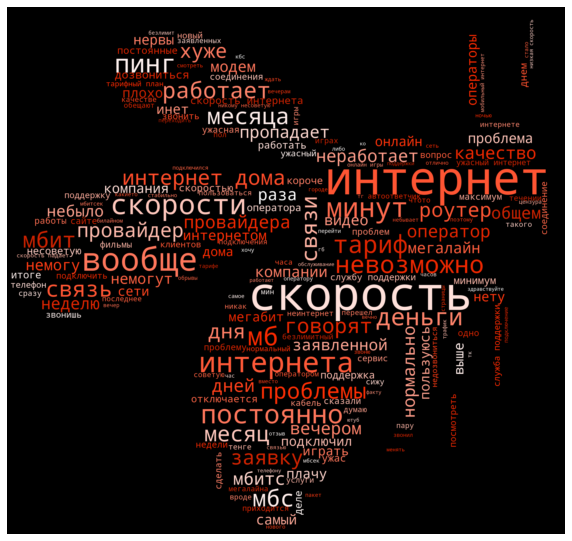

In [37]:
# Generate a word cloud image
text = " ".join(word for word in neg_tokens)
mask =  np.array(Image.open("..//Beeline KZ/images/bee.png"))
wordcloud = WordCloud(background_color="black", mask=mask).generate(text)

def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(10, 100%%, %d%%)" % random.randint(40, 100)

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=red_color_func), interpolation="bilinear")
plt.axis("off")
# plt.savefig('..//Beeline KZ/images/neg_words_cloud_2.jpeg', bbox_inches='tight')
plt.show()

Теперь мы видим что появились такие важные для анализа слова как "неработает", "немогу", "несоветую" и т.д. Как вы уже поняли __сентимент анализ__ текста — это очень тонкое и скрупулёзное искусство, требующее знание основ морфологии, семантики, синтаксиса русского языка. Имея данные навыки, можно совершенствовать алгоритмы _"токенизации"_ текста.

# Классификатор отзывов

Нашим последним шагом будет использование машинного обучения для прогнозирования отзывов. Целью модели машинного обучение будет распознавание положительных и отрицательных отзывов. Такой классификатор очень полезен в производстве для оценивания качества услуг. Так как пишется минимум по 1 отзыву в день, то нет необходимости их читать и анализировать. Достаточно загрузить новый датасет в обученную модель и она определит количество положительный и отрицательных отзывов.

Конечно это все я описал очень абстрактно, на деле в производстве эти алгоритмы на много сложнее, обрабатывают больше переменных и выполняют одновременно несколько задач. Наш же классификатор будет очень-очень простым без каких-либо гипер параметров и наворотов. И нашей задачей будет просто понять принцип работы алгоритма.

Так как ML модели очень капризные и любят работать только с числами, нам придется переводить все слова в единички и нолики. Другими словами векторизовать их. Для этого уже придумали и разработали все библиотеки, так что вам ничего не надо делать. Только разделим наши данные на тренировочные и тестируемые, чтобы избежать переобучения, и оценить качество нашей модели.

Если очень много различных видов классификаторов, но сегодня мы будем использовать алгоритмы на основе [Наивного Байеса](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B2%D0%BD%D1%8B%D0%B9_%D0%B1%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80). Если вы знакомы с теоремой Байеса, то понять как работает этот классификатор вам будет несложно. Ну а если нет, то статья в [Википедии](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%B0) вам в помощь.

In [38]:
# Create a series to store the labels: y
y = reviews["sentiment"]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews["Отзыв"], y,
test_size=0.33, random_state=314)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words=stop_words)

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train.values)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test.values)

# Print the first 10 features of the count_vectorizer
print(count_vectorizer.get_feature_names()[:10])

['00', '000', '0010321356', '01', '01mbps', '02', '028', '03', '03mbps', '04ноя']


In [39]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score.round(2))

0.85


Точность нашей модели составляет 85%, что не так уж и плохо. Мы можем улучшить этот показатель подбирая различные параметры или добавляя все больше данных. Давайте посмотрим на _confusion matrix_, что оценить долю правильно/не правильно классифицированных отзывов.

In [40]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=[1,0])

# add col and row names
cm = pd.DataFrame(cm, columns=['Положительный', 'Негативный'])\
  .rename({0:'Положительный', 1:'Негативный'}, axis=0)

print(cm)

               Положительный  Негативный
Положительный             35          34
Негативный                 2         162


В итоге наша модель правильно классифицировала 35 положительных и 162 отрицательных отзыва. 2 негативных отзыва были классифицированны как положительные и 34 положительных отзыва были классифицированны как негативные. 

# Заключение
В ходе данного проекта были обнаружены очень занятные наблюдения. И я думаю их может быть больше при пристальном изучении всех графиков и таблиц. Но так как задачей было практика и улучшение моих навыков программирования и визуализации, то можно сказать, что задача выполнена:) Конечно же есть вероятность того, что мои выводы и предположения могут быть ошибочны, что еще раз доказывает как важно иметь знание в индустрии обрабатываемых данных. Другими слова, необходимо понимать структуру работы в сфере мобильных операторов таких как "Beeline KZ", чтобы понять, почему происходит то, что происходит.

Этот проект так же показал сколько всего я не знаю и сколько всего интересного необходимо будет изучить, чтобы добиться максимально эффективной обработки и анализа данных. Таков путь дата аналитика:)